In [1]:

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import hdbscan
from scipy.sparse import hstack

In [2]:
df = pd.read_csv('/content/drive/MyDrive/DATA/cleaned_embedding_data.csv')

In [3]:

def parse_embedding(text):
    try:
        cleaned = text.strip('[]').split()
        return [float(x) for x in cleaned]
    except:
        return np.nan

df['embedding_vector'] = df['foi_embedding'].astype(str).apply(parse_embedding)
df = df.dropna(subset=['embedding_vector'])

In [ ]:

X_text = np.vstack(df['embedding_vector'].values)

In [ ]:

pca = PCA(n_components=50, random_state=42)
X_text_reduced = pca.fit_transform(X_text)

In [ ]:

np.save('/content/drive/MyDrive/DATA/foi_embeddings_reduced.npy', X_text_reduced)

In [1]:

import numpy as np
X_text_reduced = np.load('/content/drive/MyDrive/DATA/foi_embeddings_reduced.npy')


print("Reduced shape:", X_text_reduced.shape)

Reduced shape: (462682, 50)


In [4]:
import pandas as pd


df = pd.read_csv('/content/drive/MyDrive/DATA/cleaned_embedding_data.csv')

print("Shape of DataFrame:", df.shape)

Shape of DataFrame: (462682, 45)


In [6]:

structured_cols = ['brand_name', 'event_type', 'device_operator', 'device_availability']
structured_df = df[structured_cols].copy()


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

encoder = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown='ignore'), structured_cols)
])

X_structured = encoder.fit_transform(structured_df)

In [8]:


from scipy.sparse import hstack

X_combined = hstack([X_structured, X_text_reduced])

In [10]:

from sklearn.ensemble import IsolationForest

iso_model = IsolationForest(contamination=0.01, random_state=3)


X_combined_dense = X_combined.toarray()


df['iso_anomaly'] = (iso_model.fit_predict(X_combined_dense) == -1).astype(int)  # 1 = anomaly, 0 = normal

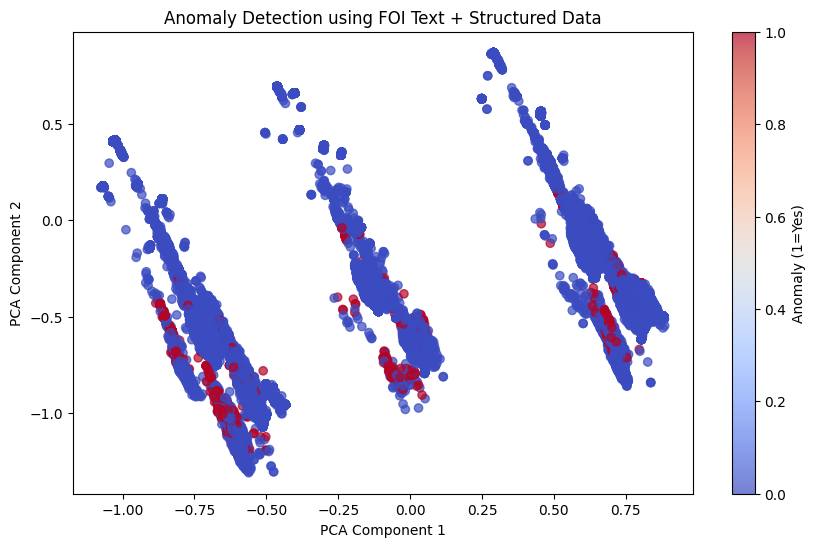

In [13]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca_vis = PCA(n_components=2, random_state=3)
X_vis = pca_vis.fit_transform(X_combined.toarray() if hasattr(X_combined, 'toarray') else X_combined)

plt.figure(figsize=(10, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=df['iso_anomaly'], cmap='coolwarm', alpha=0.7)
plt.title('Anomaly Detection using FOI Text + Structured Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Anomaly (1=Yes)')
plt.show()

In [15]:

top_anomalies = df[df['iso_anomaly'] == 1].sort_values(by='iso_anomaly', ascending=False).head(10)
print(top_anomalies[['foi_text']])

                                                 foi_text
462608  (b)(4). diabetes mellitus is a known cause of ...
317     subsequent to the initial mdr, additional info...
391     subsequent to the initial mdr, additional info...
461559  senseonics was made aware of an incident where...
461558  the manufacturer is currently performing an in...
461553  the customer did not return the suspected devi...
461552  an advocate from (b)(6) reported that the cust...
461551  the patient/family was the initial reporter, s...
461364  consumer reported complaint for e-3 error code...
461315  on november 18, 2019, senseonics was made awar...


AutoEncoders

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

input_dim = X_text_reduced.shape[1]  # 50 dimensions

input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation='relu')(input_layer)
encoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

In [18]:

history = autoencoder.fit(X_text_reduced, X_text_reduced,
                          epochs=30,
                          batch_size=8,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1)

Epoch 1/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 142s 3ms/step - loss: 7.3925e-04 - val_loss: 0.0011
Epoch 2/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 131s 2ms/step - loss: 3.0011e-04 - val_loss: 0.0010
Epoch 3/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 136s 3ms/step - loss: 2.9094e-04 - val_loss: 0.0010
Epoch 4/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - loss: 2.8702e-04 - val_loss: 0.0010
Epoch 5/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 144s 3ms/step - loss: 2.7953e-04 - val_loss: 0.0010
Epoch 6/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 141s 3ms/step - loss: 2.7610e-04 - val_loss: 0.0010
Epoch 7/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 135s 3ms/step - loss: 2.7584e-04 - val_loss: 0.0010
Epoch 8/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step - loss: 2.7550e-04 - val_loss: 0.0010
Epoch 9/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 152s 3ms/step - loss: 2.7370e-04 - val_loss: 0.0010
Epoch 10/30
52052/52052 ━━━━━━━━━━━━━━━━━━━━ 196s 3ms/step - loss: 2.7195e-04 - val_loss: 0.0010
Epoch 11/30
52052/52052 ━━━━━━━━━━━━━━━

In [19]:

X_reconstructed = autoencoder.predict(X_text_reduced)
reconstruction_errors = np.mean(np.square(X_text_reduced - X_reconstructed), axis=1)

14459/14459 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step


In [20]:

threshold = np.percentile(reconstruction_errors, 95)  # Top 5% errors are anomalies
df['ae_reconstruction_error'] = reconstruction_errors
df['ae_anomaly'] = (df['ae_reconstruction_error'] > threshold).astype(int)

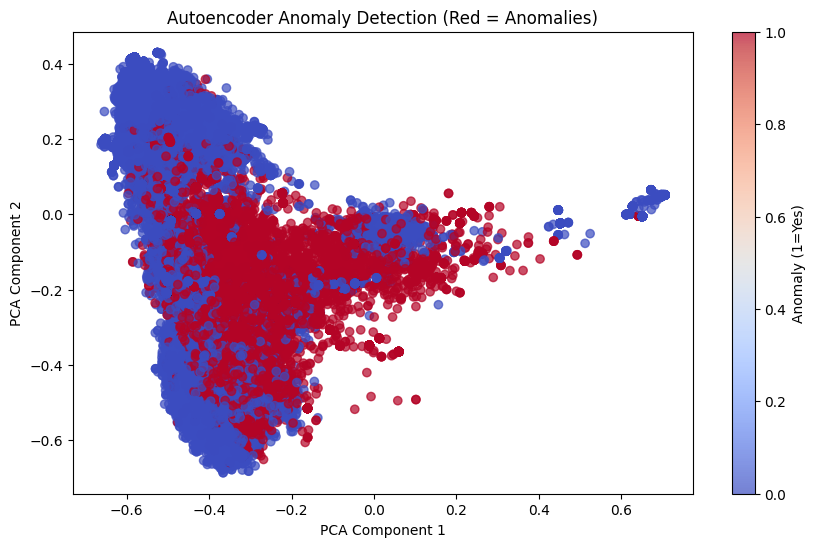

In [21]:

pca_vis = PCA(n_components=2, random_state=42)
X_vis = pca_vis.fit_transform(X_text_reduced)

plt.figure(figsize=(10, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=df['ae_anomaly'], cmap='coolwarm', alpha=0.7)
plt.title('Autoencoder Anomaly Detection (Red = Anomalies)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Anomaly (1=Yes)')
plt.show()

In [22]:
df.to_csv('/content/drive/MyDrive/DATA/foi_final_autoencoder_anomalies.csv', index=False)